### Module Importation

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy
import cv2 as cv

import h5py
import pickle
import os
import glob

# auto reload modules 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Users/sebas/git')

import icewave.tools.datafolders as df
import icewave.tools.matlab2python as mat2py
import icewave.tools.matlab_colormaps as matcmaps
import icewave.sebastien.set_graphs as set_graphs
import icewave.tools.interactive_scatter_filter as scatter_filter
import icewave.tools.Fourier_tools as FT
import icewave.drone.drone_projection as dp

# PARULA COLORMAP 
parula_map = matcmaps.parula()

full_blues = mpl.colormaps['Blues'].resampled(256)
new_blues = colors.ListedColormap(full_blues(np.linspace(0.2,1,256)))

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Function section 

In [2]:
def matrix_peak_correlation_detection(M,x,y,x_range,y_range,model_signal,detec_param):
    """ Perform peak detection using gaussian correlation 
    Inputs : - M, numpy.ndarray [ny,nx]: matrix over which we perform peak detection
             - x, array type (nx,) : detection is performed at fixed x
             - y, array type (ny,): correlation is performed with respect to y coordinate
             - x_range,y_range, array (2,) : range of x and y over which we look for maxima
             - model_signal, array type (ny,): reference array used to perform correlation
             - detec_param, dict : parameters dictionnary to be used for find_peaks """
    
    delta_y = np.diff(y)[0]
    
    mask_y = np.where(np.logical_and(y < y_range[1],y > y_range[0]))[0]
    y = y[mask_y]
    M = M[mask_y,:]

    idx_min = np.argmin(np.abs(x_range[0] - x))
    idx_max = np.argmin(np.abs(x_range[1] - x))
    indices = np.arange(idx_min,idx_max,step = 1)

    # parameters for find peaks
    min_prominence = detec_param['prominence']
    rel_height = detec_param['rel_height']
    
    S = {'idx':[],'peaks':[],'A':[],'y':[],'x':[]}
    # create dictionnary in which results are saved 
    
    fig, ax = plt.subplots()
    for i in range(len(indices)):
        ax.clear()
        
        idx = indices[i]
        
        detected_x = x[idx]
        print(detected_x)
        section = M[:,idx]
        label_x = f'x = {detected_x:.2f}'
        
        norm = section/section.max()
        
        ax.plot(y,norm,'-o',label = label_x)
        x_model = np.arange(0,len(model_signal),step = 1)*delta_y
        ax.plot(x_model,model_signal,'-k')
        
        # Apply gaussian filter 
        correlated = scipy.signal.fftconvolve(norm,model_signal,mode = 'same')
        norm_correlated = correlated/correlated.max()
        ax.plot(y,norm_correlated)
        # find peaks of correlation
        peaks,properties = scipy.signal.find_peaks(norm_correlated,prominence = min_prominence)
        prominences = scipy.signal.peak_prominences(norm_correlated,peaks)
        widths = scipy.signal.peak_widths(norm_correlated,peaks,rel_height = rel_height)
        ax.vlines(x=y[peaks], ymin=norm_correlated[peaks] - prominences[0],
                ymax = norm_correlated[peaks],color = 'g')
        ax.hlines(y=widths[1], xmin= y_range[0] + widths[2]*delta_y,
                xmax=y_range[0] + widths[3]*delta_y,color = 'g')
        
        ax.plot(y[peaks],norm_correlated[peaks],'d')
        
        ax.set_xlabel(r'$y \; \mathrm{(Hz)}$')
        ax.set_ylabel(r'$A_{norm}$')
        ax.legend()
        
        plt.pause(1.0)
        # save parameters in dictionnary
        for i,p in enumerate(peaks) :
            S['idx'].append(idx)
            S['peaks'].append(p)
            S['A'].append(norm[p]*section.max())
            S['x'].append(detected_x)
            S['y'].append(y[p])
        
        detected_y = y[p]
        print(f'y = {detected_y}')
        # f_txt = f'{detected_f:.2f}'.replace('.','p')
        # figname = f'{fig_folder}Section_f{f_txt}_corr_gaussian_sigma{gaussian_width}'
        # plt.savefig(figname + '.pdf', bbox_inches='tight')
        # plt.savefig(figname + '.png', bbox_inches='tight')
        
    for key in S.keys():
        S[key] = np.array(S[key])

    return S

def peaks_from_convolution(signal,model_signal,prominence = None,height = None,width = None):
    """ Perform peak detection from the convolution of a signal and a model signal (typically a gaussian) 
    Inputs : - signal, 1D array like, signal from which we want to detect peaks
             - model_signal, 1D array like, model signal. Peaks should have a shape close to the model signal for a maximum
             correlation
             - prominence,height and width, arguments that are used by scipy.signal.find_peaks. 
    Outputs :  - peaks, array like, detected peaks, indices of the input array signal
               - properties, properties of the detected peaks, returned by scipy.signal.find_peaks """
    
    norm = signal/signal.max()
    correlated = scipy.signal.fftconvolve(norm,model_signal,mode = 'same')
    norm_correlated = correlated/correlated.max()
    peaks,properties = scipy.signal.find_peaks(norm_correlated,prominence = prominence,height = height,width = width)

    return peaks,properties

### Import Data

In [3]:
base = 'F:/Rimouski_2024/Data/'
date = '0226'
drone_ID = 'mesange'
exp_ID = '10-waves_005'

path2data = f'{base}{date}/Drones/{drone_ID}/matData/{exp_ID}/'
filelist = glob.glob(f'{path2data}*scaled.mat')
print(filelist)

idx_file = 0
file2load = filelist[idx_file]

# load file 
with h5py.File(file2load, 'r') as fmat:
    S = {}
    print('Top-level keys : ', list(fmat.keys()))
    S = mat2py.mat_to_dict(fmat['m'],fmat['m'])
    S = mat2py.transpose_PIVmat_fields(S)

['F:/Rimouski_2024/Data/0226/Drones/mesange/matData/10-waves_005\\PIV_processed_i00_Dt5_b1_W32_xROI600_width3240_yROI1_height2159_scaled.mat']
Top-level keys :  ['#refs#', '#subsystem#', 'm']


In [4]:
Vx = FT.supress_quadratic_noise(np.transpose(S['Vx'],(1,0,2)),S['x'],S['y'])
Vy = FT.supress_quadratic_noise(np.transpose(S['Vy'],(1,0,2)),S['x'],S['y'])
Vx = np.transpose(Vx,(1,0,2))
Vy = np.transpose(Vy,(1,0,2))
# Vx = np.flip(Vx,(0,1))
# Vy = np.flip(Vy,(0,1))

print('Quadratic field supressed')

Supressing quadratic noise...
Quadratic noise supressed
Supressing quadratic noise...
Quadratic noise supressed
Quadratic field supressed


### Show apparent velocity fields $V_x$ and $V_y$

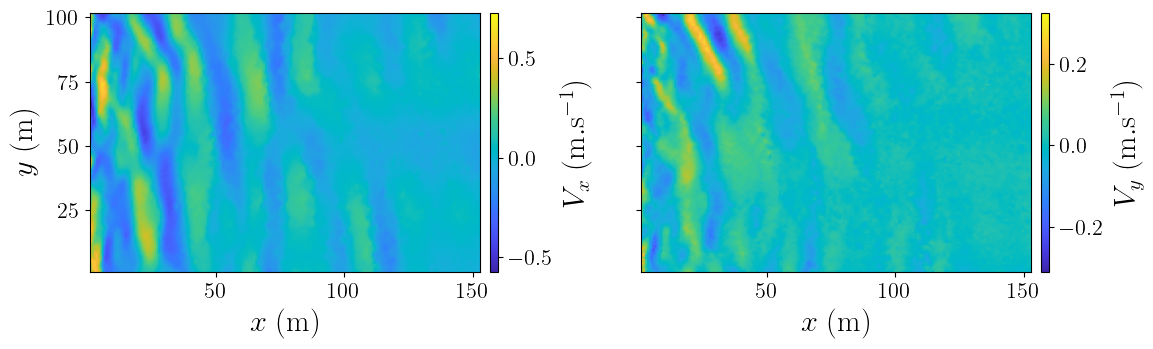

In [5]:
frame = 0
extents_meter = np.array([S['x'].min(),S['x'].max(),S['y'].min(),S['y'].max()])
extents_pix = np.array([S['PIXEL']['x_pix'].min(),S['PIXEL']['x_pix'].max(),
                    S['PIXEL']['y_pix'].min(),S['PIXEL']['y_pix'].max()])

set_graphs.set_matplotlib_param('single')
fig, axs = plt.subplots(ncols = 2,sharey = True, figsize = (12,8))
imsh = axs[0].imshow(Vx[:,:,frame].T,cmap = parula_map,origin = 'lower',aspect = 'equal',extent = extents_meter)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$V_x \; \mathrm{(m.s^{-1})}$')

imsh = axs[1].imshow(Vy[:,:,frame].T,cmap = parula_map,origin = 'lower',aspect = 'equal',extent = extents_meter)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$V_y \; \mathrm{(m.s^{-1})}$')

axs[0].set_ylabel(r'$y \; \mathrm{(m)}$')
for ax in axs:
    ax.set_xlabel(r'$x \; \mathrm{(m)}$')

plt.tight_layout()

### Compute projected fields $u_z$ and $u_x$

In [7]:
uz,ux,err_uz = dp.get_uz_ux_from_structure(Vx,Vy,S)

### Plot spatio-temporal for $u_z$

Text(0, 0.5, '$x \\; \\mathrm{(m)}$')

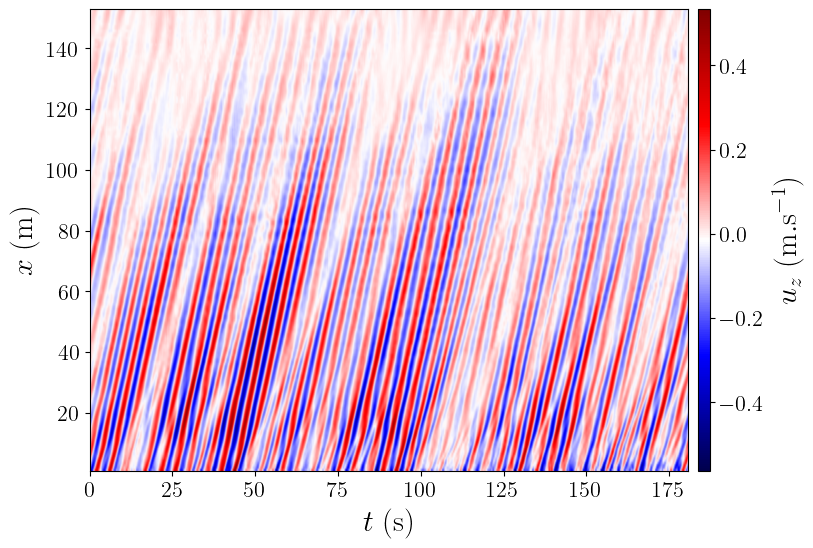

In [8]:
extents_spatio = [S['t'][0],S['t'][-1],S['x'][0],S['x'][-1]]
fig,ax = plt.subplots()
imsh = ax.imshow(uz,origin = 'lower',aspect = 'auto',cmap = 'seismic',
          interpolation = 'gaussian',extent = extents_spatio)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$u_z \; \mathrm{(m.s^{-1})}$')

ax.set_xlabel(r'$t \; \mathrm{(s)}$',labelpad = 5)
ax.set_ylabel(r'$x \; \mathrm{(m)}$',labelpad = 5)

### Plot $u_x$ VS apparent velocity $V_x$

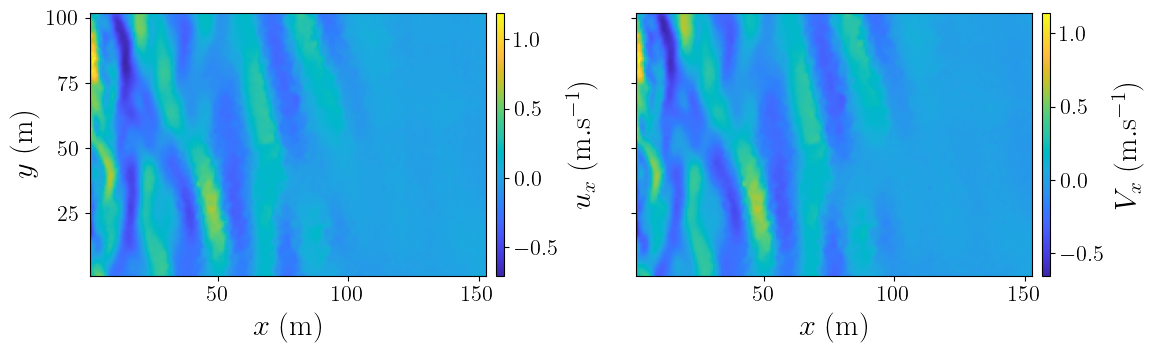

In [9]:
frame = 800
fig, axs = plt.subplots(ncols = 2,sharey = True,figsize = (12,9))
imsh = axs[0].imshow(ux[:,:,frame].T,cmap = parula_map,origin = 'lower',extent = extents_meter)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$u_x \; \mathrm{(m.s^{-1})}$')

imsh = axs[1].imshow(Vx[:,:,frame].T,cmap = parula_map,origin = 'lower',extent = extents_meter)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$V_x \; \mathrm{(m.s^{-1})}$')

axs[0].set_ylabel(r'$y \; \mathrm{(m)}$')
axs[0].set_xlabel(r'$x \; \mathrm{(m)}$')
axs[1].set_xlabel(r'$x \; \mathrm{(m)}$')

plt.tight_layout()

# Extract attenuation from $u_x$

### Compute space-time spectrum

In [14]:
ux.shape

(201, 134, 5417)

In [10]:
N = ux.shape[2]
Efk = FT.space_time_spectrum(ux[:,:,:N//2],1/S['SCALE']['fx'],S['SCALE']['facq_t'],add_pow2 = [0,0,0])

Dimensions of array after padding : [256, 256, 4096]


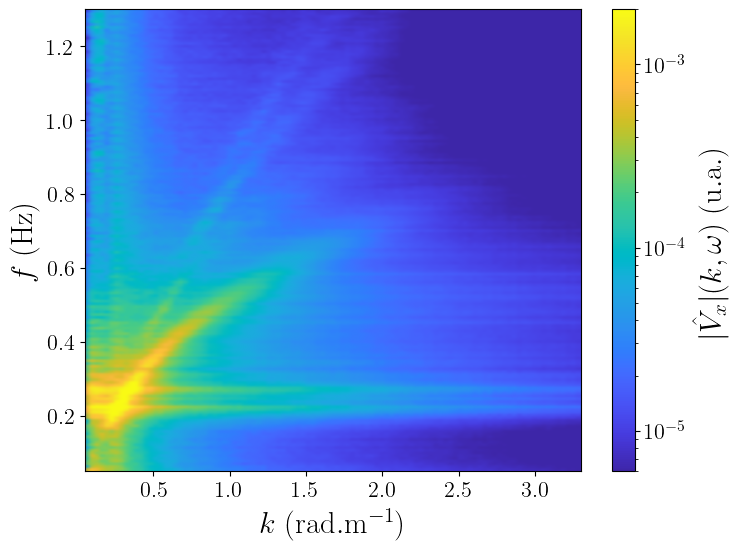

In [11]:
set_graphs.set_matplotlib_param('single')
fig, ax = plt.subplots()
Amin = 6e-6 # change to adjust colormap
Amax = 2e-3 # change to adjust colormap
c = ax.imshow(Efk['E'], cmap = parula_map , aspect = 'auto', norm = 'log', vmin = Amin,vmax = Amax,
              origin = 'lower', interpolation = 'gaussian',
              extent = (Efk['k'].min(),Efk['k'].max(),Efk['f'].min(),Efk['f'].max()))

# ax.set_xscale('log')
# ax.set_yscale('log')
kbounds = [0.05,3.3] # bounds for k axis on Efk plot
fbounds = [0.05,1.3] # bounds for f axis on Efk plot
ax.set_xlim(kbounds)
ax.set_ylim(fbounds)

ax.set_xlabel(r'$k \; \mathrm{(rad.m^{-1})}$', labelpad = 5)
ax.set_ylabel(r'$f \; \mathrm{(Hz)}$', labelpad = 5)

cbar = plt.colorbar(c,ax = ax)
cbar.set_label(r'$|\hat{V}_x| (k,\omega) \; \mathrm{(u.a.)}$',labelpad = 5)

### Extract peaks from space-time spectrum

In [12]:
print(Efk.keys())
print(Efk['E'].shape)

dict_keys(['E', 'shift', 'k', 'f', 'kx', 'ky'])
(2048, 182)


0.01614087345008274


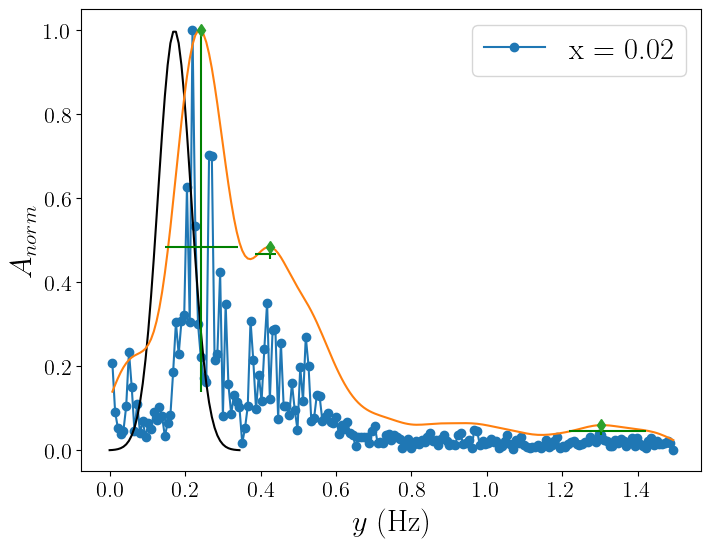

y = 1.3037109375
0.04842262035024821
y = 1.36962890625
0.08070436725041369
y = 1.38427734375
0.11298611415057917
y = 1.38427734375
0.14526786105074466
y = 1.2451171875
0.1775496079509101
y = 0.2197265625
0.20983135485107562
y = 0.2197265625
0.24211310175124107
y = 0.22705078125
0.27439484865140656
y = 0.234375
0.306676595551572
y = 0.25634765625
0.3389583424517375
y = 0.27099609375
0.37124008935190295
y = 0.2783203125
0.4035218362520685
y = 0.29296875
0.43580358315223394
y = 0.31494140625
0.46808533005239944
y = 0.32958984375
0.5003670769525649
y = 0.34423828125
0.5326488238527304
y = 0.35888671875
0.5649305707528959
y = 0.380859375
0.5972123176530614
y = 0.38818359375
0.6294940645532268
y = 0.40283203125
0.6617758114533923
y = 0.41748046875
0.6940575583535578
y = 0.4248046875
0.7263393052537233
y = 0.439453125
0.7586210521538888
y = 0.44677734375
0.7909027990540541
y = 0.4541015625
0.8231845459542196
y = 0.46875
0.8554662928543851
y = 0.47607421875
0.8877480397545506
y = 0.4833984375


In [12]:
Afk = Efk.copy()
# Build Gaussian to be convoluted (can change gaussian width to detect more or less peaks)
gaussian_width = 6
N = 8
gaussian = scipy.signal.windows.gaussian(M = gaussian_width * N,std = gaussian_width)
detec_param = {'prominence':1e-2,'rel_height':0.6} # parameters for find_peaks
wavevector_range = [0.01,2.5] # range of wavevector spanned
frequency_range = [0,1.5] # range of frequency over which we look for peaks

Speaks = matrix_peak_correlation_detection(Efk['E'], Efk['k'], Efk['f'], wavevector_range, frequency_range, 
                                      gaussian, detec_param)
# change key name
Speaks['k'] = Speaks['x']
Speaks['f'] = Speaks['y']
del Speaks['x']
del Speaks['y']

### Filter detected peaks

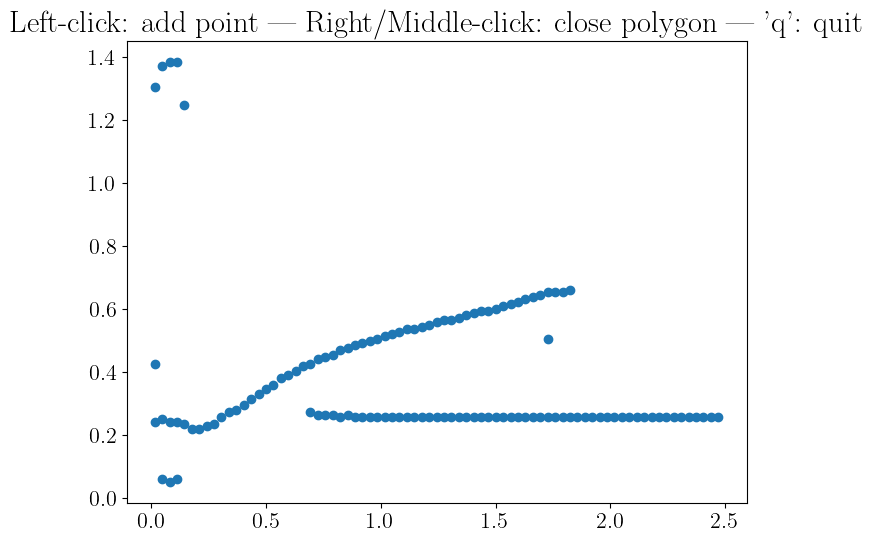

KeyboardInterrupt: 

In [17]:
set_graphs.set_matplotlib_param('single')
filtered_x,filtered_y,filtered_properties = scatter_filter.interactive_scatter_filter(Speaks['k'], Speaks['f'],Speaks)

fig, ax = plt.subplots()
ax.plot(filtered_properties['k'],filtered_properties['f'],'o')
c = ax.imshow(Efk['E'], cmap = parula_map , aspect = 'auto', norm = 'log', vmin = Amin,vmax = Amax,
              origin = 'lower', interpolation = 'gaussian',
              extent = (Efk['k'].min(),Efk['k'].max(),Efk['f'].min(),Efk['f'].max()))

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(kbounds)
ax.set_ylim(fbounds)

ax.set_xlabel(r'$k \; \mathrm{(rad.m^{-1})}$', labelpad = 5)
ax.set_ylabel(r'$f \; \mathrm{(Hz)}$', labelpad = 5)

cbar = plt.colorbar(c,ax = ax)
cbar.set_label(r'$|\hat{V}_x| (k,\omega) \; \mathrm{(u.a.)}$',labelpad = 5)

# save filtered_properties
# file2save = f'{fig_folder}Filtered_peaks_respectto_f_fixed_k_{date}_{drone_ID}_{exp_ID}.h5'
# rw.save_dict_to_h5(filtered_properties, file2save)
# print('DONE.')

### Get peak width - waves attenuation

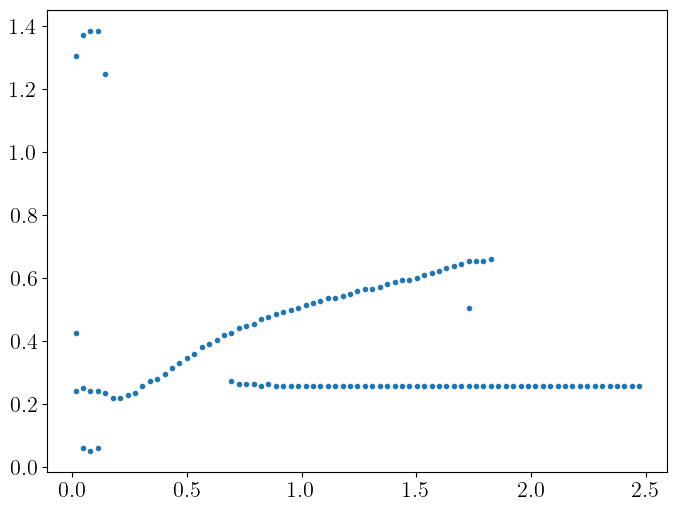

In [15]:
fig, ax = plt.subplots()
ax.plot(Speaks['k'],Speaks['f'],'.')